## simple ResNet

In [1]:
import torch
import numpy as np
from torch import nn
from torch.nn import functional
import matplotlib.pyplot as plt
import ipywidgets

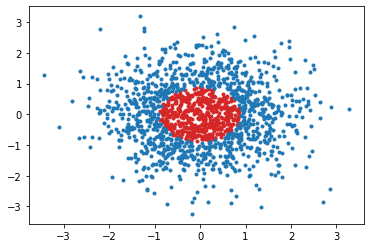

In [2]:
# number of features in
nf   = 2
# number of classes
nClass = 2

X = torch.randn(2,1500)
R = torch.sqrt(X[0,:]**2 + X[1,:]**2)
indRed   = (R < 0.9).nonzero()
indBlue  = (R >= 0.9).nonzero()


C = torch.zeros(1500,dtype = torch.int64)
C[indRed]  = 0
C[indBlue] = 1

plt.plot(X.numpy()[0,indRed],X.numpy()[1,indRed],'.C3')
plt.plot(X.numpy()[0,indBlue],X.numpy()[1,indBlue],'.C0')

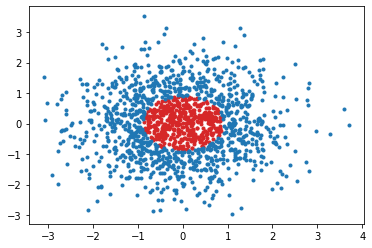

In [3]:
# Get a validation set
XVal = torch.randn(2,1500)
R = torch.sqrt(XVal[0,:]**2 + XVal[1,:]**2)
indRed   = (R < 0.9).nonzero()
indBlue  = (R >= 0.9).nonzero()


CVal = torch.zeros(1500,dtype = torch.int64)
CVal[indRed]  = 0
CVal[indBlue] = 1

plt.plot(XVal.numpy()[0,indRed],XVal.numpy()[1,indRed],'.C3')
plt.plot(XVal.numpy()[0,indBlue],XVal.numpy()[1,indBlue],'.C0')

In [4]:
lossFunc = nn.CrossEntropyLoss()

def misfit(X, W, bias, C):
    n = W.shape
    X = X.view(n[1], -1)
    S = torch.matmul(W, X) 
    S += bias.unsqueeze(1)
    return lossFunc(S.t(),C), S

In [5]:
class ResNet(nn.Module):

    def __init__(self, nt=64, dt=0.1, gamma=1e-3):
        super().__init__()
        
        self.nt = nt
        self.dt = dt
        self.gamma = gamma
        
    def forward(self, x, K, b, K0=None):
        
        if K0 is not None: 
            x = torch.matmul(K0, x)
        
        # Allocate space for all times
        X = torch.zeros(x.shape[0], x.shape[1], self.nt+1)
        X[:, :, 0] = x
        
        # forward Euler
        for i in range(self.nt):
            Ki = self.M_imag_eigs(K[i])
            z = torch.matmul(Ki, x)
            x = x + self.dt * functional.relu(z+b[i])
            ind = i+1
            X[:, :, ind] = x

#             k1 = functional.relu(torch.matmul(K[i], x) + b[i])
#             k2 = functional.relu(torch.matmul(K[i], x+k1/2.0) + b[i])
#             k3 = functional.relu(torch.matmul(K[i], x+k2/2.0) + b[i])
#             k4 = functional.relu(torch.matmul(K[i], x+k3) + b[i])

#             x = x + self.dt/6.0*(k1+k2+k3+k4)
#             ind = i+1
#             X[:,:,ind] = x
  
        return x, X

    def M_imag_eigs(self, K):
        return 0.5*(K - K.t() - self.gamma*torch.eye(K.shape[0]))

In [6]:
dt = 0.1
nt = 64
nf_net = 3
net = ResNet(dt=dt, nt=nt, gamma=1e-2)

# initialize K's
K0 = nn.Parameter(torch.randn(nf_net, nf), requires_grad=True)
K = []
for i in range(nt):
    Ki = nn.Parameter(torch.randn(nf_net, nf_net)*1e-3, requires_grad=True)
    K.append(Ki)
    
b = nn.Parameter(torch.randn(nt)*1e-3)

In [7]:
# Run the network
xF, Xpath = net(X,K,b,K0)

In [8]:
# weights for linear classifier    
W = nn.Parameter(torch.randn(nClass, nf_net)*1e-3, requires_grad=True)
bW = nn.Parameter(torch.randn(nClass)*1e-2, requires_grad=True)

nparout = np.prod(W.shape) + np.prod(bW.shape) + np.prod(K[0].shape)*nt + nt

print('Total number of parameter',nparout)
print('Total number of data',C.shape[0])

Total number of parameter 648
Total number of data 1500


In [9]:
# run the network
x, _ = net(X, K, b, K0)
label = C
loss, S = misfit(x, W, bW, label)
print('Initial loss = ', loss.detach().numpy())    
print('Sanity Check = ', np.log(2.0))

Initial loss =  0.6966352
Sanity Check =  0.6931471805599453


In [10]:
batchSize = 16

In [11]:
import torch.optim as optim
optimizer = optim.SGD(
    [{'params': W}, {'params': K}, {'params': K0}, {'params': bW}, {'params': b}], 
    lr = 1e0, momentum=0
)


In [12]:
for epoch in range(30):  # loop over the dataset multiple times

    # zero the parameter gradients
    g = 0.0
    loss = 0.0
    ind = 0
    
    while ind < X.shape[1]:    
        optimizer.zero_grad()
        # get the inputs
        inputs = X[:,ind:ind+batchSize]
        labels = C[ind:ind+batchSize]

        # forward 
        x,_ = net(inputs, K, b, K0)
        lossi, _ = misfit(x, W, bW, labels)
        if i==0:
            loss = lossi
        else:
            loss += lossi
        
        lossi.backward()
        optimizer.step()
        g += torch.norm(W.grad) + torch.norm(bW.grad)    
        ind += batchSize
        
    print('%d  %.3f   %.3f'% (epoch+1, loss, g))

print('Finished Training')

1  61.327   27.992
2  55.715   30.205
3  47.879   36.820
4  45.117   39.334
5  32.067   46.411
6  18.754   34.047
7  14.597   30.410
8  13.714   30.119
9  13.395   30.420
10  13.587   31.589
11  13.622   32.200
12  12.979   31.335
13  12.552   31.665
14  15.092   34.509
15  13.645   32.409
16  13.795   32.293
17  12.311   32.050
18  11.203   29.566
19  12.150   31.432
20  12.350   31.624
21  12.578   31.041
22  11.749   30.372
23  10.487   27.672
24  11.228   29.385
25  10.701   28.686
26  10.595   28.515
27  10.086   27.487
28  10.044   27.145
29  10.948   29.747
30  12.239   31.624
Finished Training


In [13]:
S

tensor([[ 0.0171,  0.0147,  0.0157,  ...,  0.0157,  0.0147,  0.0170],
        [-0.0059, -0.0051, -0.0058,  ..., -0.0055, -0.0049, -0.0066]],
       grad_fn=<AddBackward0>)

Validation loss =  13.028311


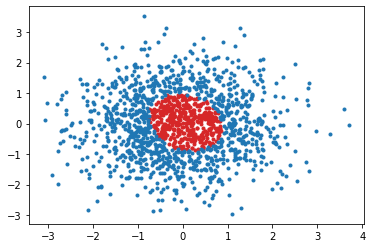

In [15]:
x,_ = net(XVal, K, b, K0)
S = torch.matmul(W,x)
S += bW.unsqueeze(1)
Cpred = functional.softmax(S.t(), dim=0)
_,Cpred = torch.max(S,dim=0)

label = C
loss, S = misfit(x, W, bW, label)
print('Validation loss = ', loss.detach().numpy()) 

indRed = (Cpred==0).nonzero()
indBlue = (Cpred==1).nonzero()

plt.plot(XVal[0,indRed].numpy(),XVal[1,indRed].numpy(),'.C3')
plt.plot(XVal[0,indBlue].numpy(),XVal[1,indBlue].numpy(),'.C0')

In [16]:
# plot the path
x, Xpath = net(X, K, b, K0)

indRed = (C==0).nonzero()
indBlue = (C==1).nonzero()

from mpl_toolkits.mplot3d import Axes3D

def plot_path(i):
    if nf_net == 3: 
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')

        Xi = Xpath[:, :, i].detach().numpy()
        ax.scatter(Xi[0,indRed], Xi[1,indRed], Xi[2,indRed], color='C3')
        ax.scatter(Xi[0,indBlue], Xi[1,indBlue], Xi[2,indBlue], color='C0')
    elif nf_net == 2:
        fig, ax = plt.subplots(1, 1)

        Xi = Xpath[:, :, i].detach().numpy()
        ax.scatter(Xi[0,indRed], Xi[1,indRed], color='C3')
        ax.scatter(Xi[0,indBlue], Xi[1,indBlue], color='C0')

    ax.set_title("Time {}".format(i))

ipywidgets.interact(
    plot_path, i=ipywidgets.IntSlider(min=0, max=nt, value=0)
)
    

interactive(children=(IntSlider(value=0, description='i', max=64), Output()), _dom_classes=('widget-interact',…

<function __main__.plot_path(i)>

In [17]:
tmp = x.grad_fn
print(x.grad_fn)

tmp1, tmp2 = tmp.next_functions
print(tmp.next_functions)

print(tmp1[0].next_functions, tmp2[0].next_functions)

print("\n")
print(tmp1[0].next_functions[0][0].next_functions)
print(tmp1[0].next_functions[1][0].next_functions)
print(tmp2[0].next_functions[0][0].next_functions)



((<AddBackward0 object at 0x127e324e0>, 0), (<MulBackward0 object at 0x127e323c8>, 0))
((<AddBackward0 object at 0x127e32198>, 0), (<MulBackward0 object at 0x127e32320>, 0)) ((<ReluBackward0 object at 0x127e322b0>, 0), (None, 0))


((<AddBackward0 object at 0x127e32320>, 0), (<MulBackward0 object at 0x127e322b0>, 0))
((<ReluBackward0 object at 0x127e32390>, 0), (None, 0))
((<AddBackward0 object at 0x127e322b0>, 0),)


In [ ]:
x = torch.randn(2, requires_grad=True)
x

In [ ]:
f = functional.relu(x)
f